In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Slist = h5py.File('SatelliteList_V2_cont1R200.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]

In [5]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
#TdayTotalIDs = sim['SnapNumber_127/PartType0/ParticleIDs'][()] # need this first, thsi is not use now
I= np.identity(3) # and this

In [6]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    
    #first select the first infall moment
    
    uniqueAll = int(128*1e6+fofID)
    uniqueCen = int(128*1e6+centralID)
    
    
    streeI = networkx.dfs_tree(trees, str(uniqueAll))
    streeC = networkx.dfs_tree(trees, str(uniqueCen))
    
    mtreeI = get_main_branch_unique_ids(streeI, str(uniqueAll))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueCen))
    
    dist, snaps = [], []
    for mI, mC in zip(mtreeI, mtreeC):
        snap, iddI = split_unique_id(int(mI))
        snap, iddC = split_unique_id(int(mC))
        
        pgal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][iddI]
        group = sim['SnapNumber_{}/SubGroups/GroupNumber'.format(snap)][iddC]
        cenG = sim['SnapNumber_{}/Groups/GroupCM'.format(snap)][group]
        r200 = sim['SnapNumber_{}/Groups/Group_R_Crit200'.format(snap)][group]
        distr200T = np.sqrt(np.sum((pgal-cenG)**2.))/r200
        
        snaps.append(snap)
        dist.append(distr200T)
        
    snaps, dist = np.array(snaps), np.array(dist)
    
    ii = np.where(dist<1.)
    snapsT = snaps[ii]
    theSnap = snapsT.min()
    
    iik = np.where(snaps==theSnap)[0][0]
    mTT = mtreeI[iik]
    mCC = mtreeC[iik]
    
    snap, fofIDI = split_unique_id(int(mTT))
    snap, centralIDI = split_unique_id(int(mCC))
        
    TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()]
    
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    # and now we cut this
    mtree = mtree[:iik]
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []

    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    Idlist = np.unique(Idlist) # remove duplicates
    

    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
    distance = 200

    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is the final list of particles ids
    
    # ok, lest see velocity and stuff
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][centralID]
    velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]

    velRep = velSat - velCen
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_near]
    GassAbundances = sim['SnapNumber_128/PartType0/Abundances'][IndexT_near]
    
    NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near]

    # first lets re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posGal[0], NearCoord[:,1] - posGal[1], NearCoord[:,2] - posGal[2]
    xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2] # the direction of the centre from the galaxy
    
    # now define normalized vectors, for velocity and centre directions
    velX, velY, velZ = velRep[0], velRep[1], velRep[2]
    Vel = np.sqrt(velX**2 + velY**2 + velZ**2)
    Cen = np.sqrt(xC**2 + yC**2 + zC**2)

    velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
    xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
    
    # Then, the rotations matrix are, for velocity
    faV = (1-velx)/(vely**2+ velz**2)
    VV = np.array([[0, vely, velz], [-vely, 0, 0], [-velz, 0, 0]])
    VV2 = np.matmul(VV, VV)

    RV = I + VV + VV2*faV
    
    # and for the direction to the centre
    faC = (1-xc)/(yc**2+zc**2)
    CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
    CC2 = np.matmul(CC, CC)

    RC = I + CC + CC2*faC
    
    # lets calculate the rotated coordinates
    xRv, yRv, zRv = [], [], []
    xRc, yRc, zRc = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xRv.append(dV[0])
        yRv.append(dV[1])
        zRv.append(dV[2])
    
        xRc.append(dC[0])
        yRc.append(dC[1])
        zRc.append(dC[2])
    
    xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
    xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)
    
    # and return the 2 sets of rotated positions, masses and abundances
    return xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GassAbundances

In [7]:
# ok, lets try if this works before apply some serialized use.
xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GassAbundances = getAllLastP(33, 32)

Text(0, 0.5, 'z/(ckpc h^{-1})')

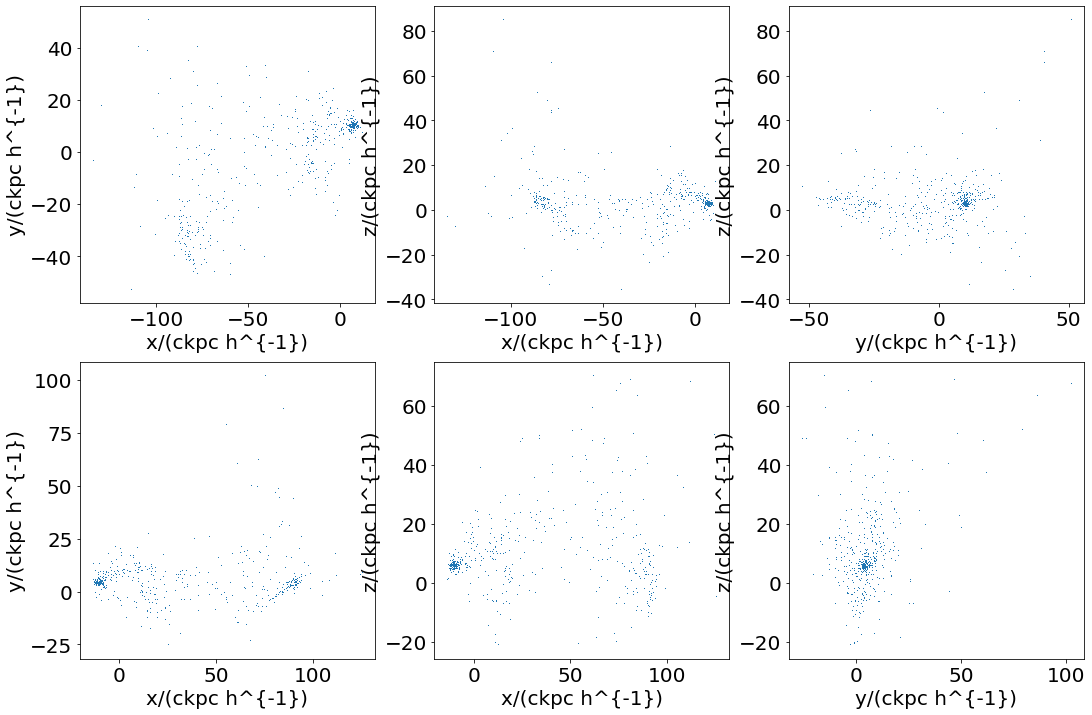

In [8]:
mark = ','
pl.figure(figsize=(18, 12))

pl.subplot(2, 3, 1)

pl.plot(xRv, yRv, marker=mark, ls='')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')
#pl.arrow(0, 0, newV[0], newV[1], color='black', width=5)

pl.subplot(2, 3, 2)

pl.plot(xRv, zRv, marker=mark, ls='')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
#pl.arrow(0, 0, newV[0], newV[2], color='black', width=5)

pl.subplot(2, 3, 3)

pl.plot(yRv, zRv, marker=mark, ls='')
pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
#pl.arrow(0, 0, newV[1], newV[2], color='black', width=5)

pl.subplot(2, 3, 4)

pl.plot(xRc, yRc, marker=mark, ls='')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')
#pl.arrow(0, 0, newC[0], newC[1], color='black', width=5)

pl.subplot(2, 3, 5)

pl.plot(xRc, zRc, marker=mark, ls='')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
#pl.arrow(0, 0, newC[0], newC[2], color='black', width=5)

pl.subplot(2, 3, 6)

pl.plot(yRc, zRc, marker=mark, ls='')
pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')
#pl.arrow(0, 0, newC[1], newC[2], color='black', width=5)

In [9]:
# and it works, lets take a look at all at the same time
import progressbar

In [10]:
size = Satellites.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

XRv, YRv, ZRv, XRc, YRc, ZRc, GASMasses, GASAbundances = [], [], [], [], [], [], [], []

for ff, cc in zip(Satellites, Centrals):
    try:
        xRv, yRv, zRv, xRc, yRc, zRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    XRv.extend(list(xRv))
    YRv.extend(list(yRv))
    ZRv.extend(list(zRv))
    XRc.extend(list(xRc))
    YRc.extend(list(yRc))
    ZRc.extend(list(zRc))
    GASMasses.extend(list(GasMasses))
    GASAbundances.extend(list(GasAbundances))
    C += 1
    bar.update(C)
    
XRv, YRv, ZRv, XRc, YRc, ZRc, GASMasses, GASAbundances = np.array(XRv), np.array(YRv), np.array(ZRv), np.array(XRc), np.array(YRc), np.array(ZRc), np.array(GASMasses), np.array(GASAbundances)
passs

  6% (33 of 515) |#                      | Elapsed Time: 0:00:08 ETA:   0:01:37<ipython-input-6-871d5c33120d>:29: RuntimeWarning: divide by zero encountered in float_scalars
  distr200T = np.sqrt(np.sum((pgal-cenG)**2.))/r200
100% (515 of 515) |######################| Elapsed Time: 0:05:44 ETA:  00:00:00

385

60952


Text(0, 0.5, 'z/(ckpc h^{-1})')

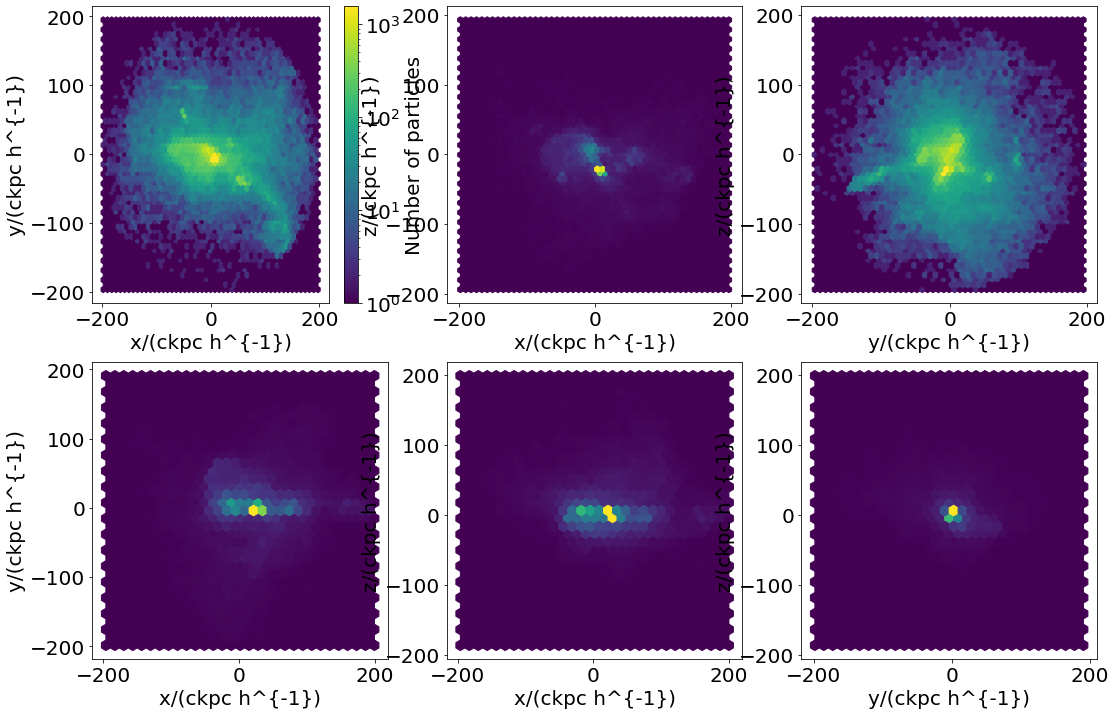

In [11]:
pl.figure(figsize=(18, 12))

pl.subplot(2, 3, 1)

print(XRv.size)

pl.hexbin(XRv, YRv, gridsize=50, bins='log')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')


pl.subplot(2, 3, 2)

pl.hexbin(XRv, ZRv, gridsize=50)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

pl.subplot(2, 3, 3)

pl.hexbin(YRv, ZRv, gridsize=50, bins='log')
pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

pl.subplot(2, 3, 4)

pl.hexbin(XRc, YRc, gridsize=30)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

pl.subplot(2, 3, 5)

pl.hexbin(XRc, ZRc, gridsize=30)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

pl.subplot(2, 3, 6)

pl.hexbin(YRc, ZRc, gridsize=30)
pl.xlabel('y/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

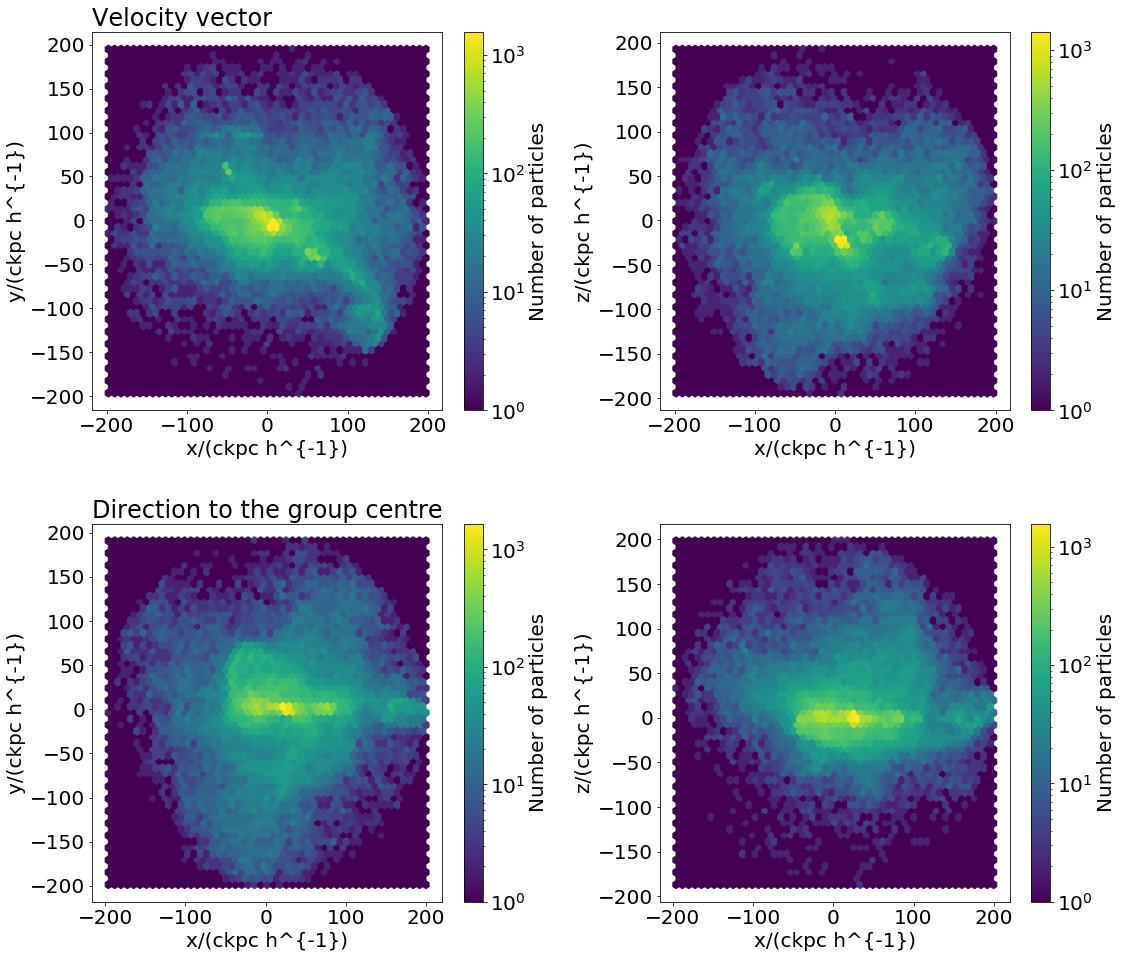

In [13]:
# lest do log, and then linear graphs
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector', loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins='log')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins='log')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins='log')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins='log')
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

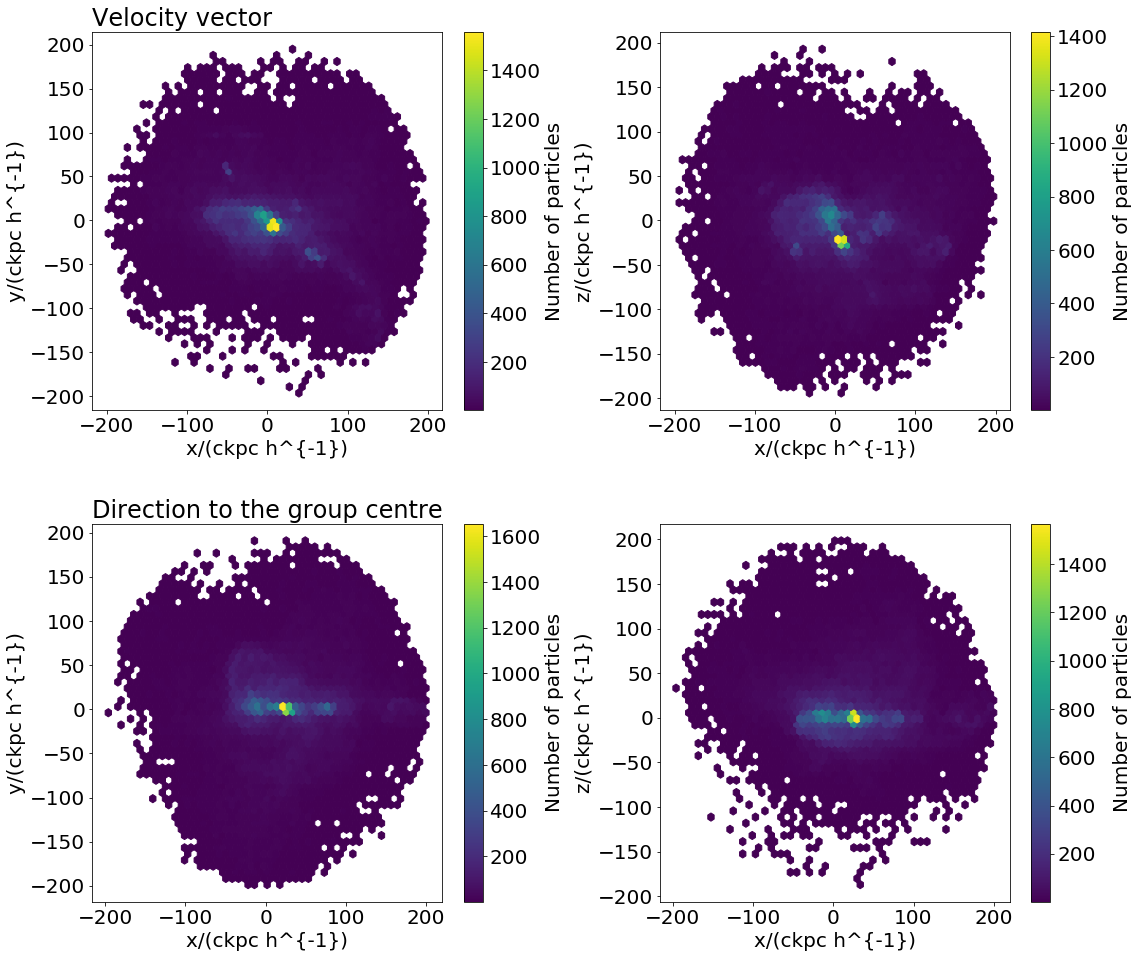

In [18]:
# lest do log, and then linear graphs
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.3, hspace=0.3)

pl.subplot(2, 2, 1)

pl.title('Velocity vector',loc='left')

pl.hexbin(XRv, YRv, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc, YRc, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, gridsize=50, bins=None, mincnt=1)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Number of particles')

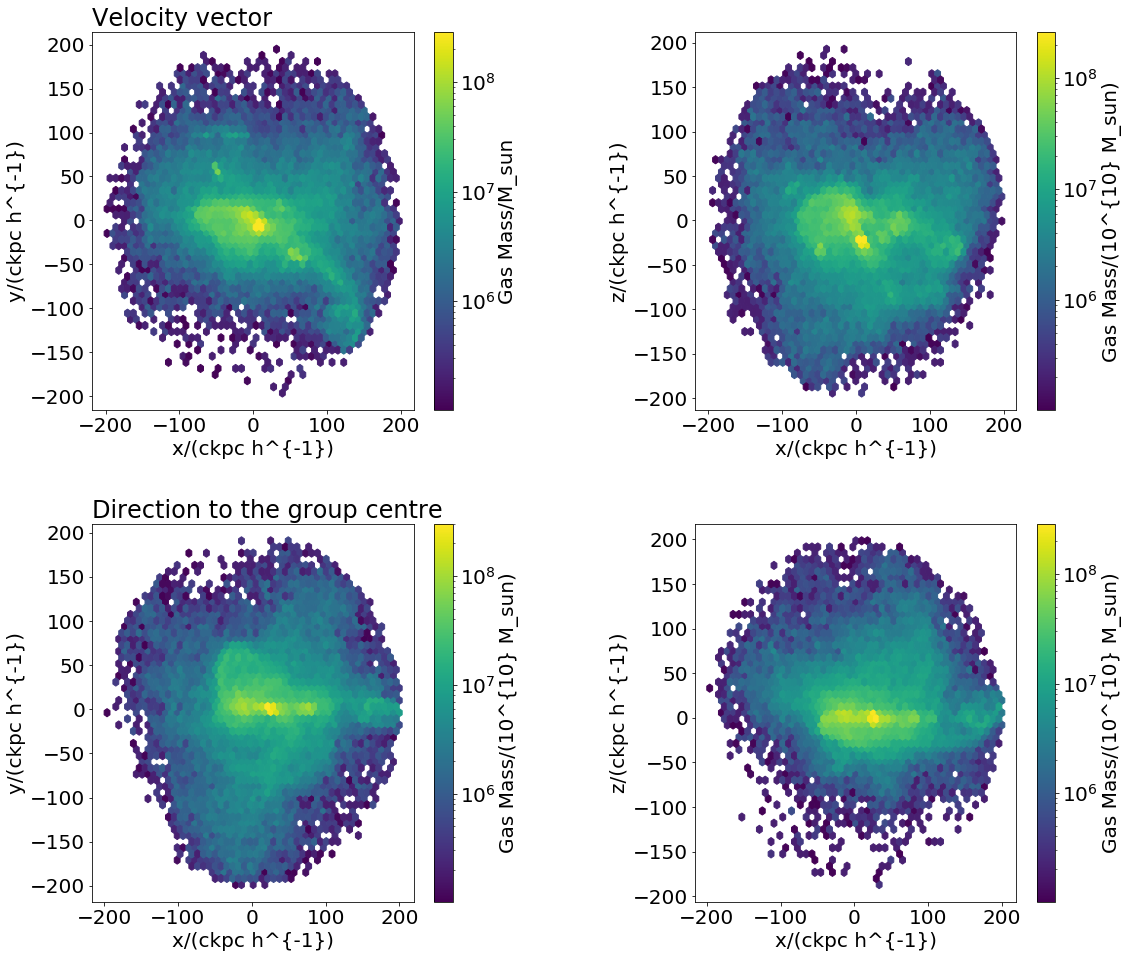

In [16]:
# and now log mass, and log Si, for instance
pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.5, hspace=0.3)
binn = 'log'

pl.subplot(2, 2, 1)

pl.title('Velocity vector', loc='left')

pl.hexbin(XRv, YRv, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/M_sun')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc, YRc, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, C=GASMasses*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

In [ ]:
sim['SnapNumber_128/PartType0/Abundances'].attrs['description']

In [ ]:
GASAbundances.shape

In [ ]:
Si = GASAbundances[:,5]

pl.figure(figsize=(18, 16))

pl.subplots_adjust(wspace=0.5, hspace=0.3)
binn = 'log'

pl.subplot(2, 2, 1)

pl.title('Velocity vector', loc='left')

pl.hexbin(XRv, YRv, C=Si*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/M_sun')

pl.subplot(2, 2, 2)

pl.hexbin(XRv, ZRv, C=Si*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

pl.subplot(2, 2, 3)

pl.title('Direction to the group centre', loc='left')

pl.hexbin(XRc, YRc, C=Si*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('y/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

pl.subplot(2, 2, 4)

pl.hexbin(XRc, ZRc, C=Si*1e10, gridsize=50, bins=binn, reduce_C_function=np.sum)
pl.xlabel('x/(ckpc h^{-1})')
pl.ylabel('z/(ckpc h^{-1})')

bar = pl.colorbar(label='Gas Mass/(10^{10} M_sun)')

In [ ]:
sim['SnapNumber_126/'].keys()